In [1]:
# from xrayutilities import Experiment, GID, QConversion
from xrayutilities import Experiment, QConversion, cxrayutilities
from xrayutilities.materials import Si,Ge
%matplotlib inline
from pylab import *
from diffractometer_swissfel import GID 
from xrayutilities import config

In [4]:
config.ENERGY = 9000.
qconv = QConversion(['y+', 'z+'], ['y+', 'z+'], [1, 0, 0])

gid = GID()

gid.Transform([1,0,0])

gid.Ang2Q(.5,0,1,0)
# gid.scatplane
# config.ENERGY

# gid.Transform([1,0,0])


qconv.transformSample2Lab([0,0,1],45,30)
gid.Ang2Q.init_area('y+','x+',500,0,1001,601, distance=10,pwidth1=0.075,pwidth2=0.075)
# gid.Ang2Q.transformSample2Lab??

Experiment.Q2Ang
gid.k0

4.078420066311271

In [39]:
qconv = QConversion(['z-', 'x+'], ['x+', 'z-'], [0, 1, 0])
qconv = QConversion(['y+', 'x+'], ['y+', 'x+'], [0, 0, 1])

gid = GID(Ge.Q(1, 0, 0), Ge.Q(0, 0, 1),qconv=qconv)
# calculate angles and print them to the screen
(alphai, azimuth, tt, beta) = gid.Q2Ang(Ge.Q(1, 0, 0))
print("azimuth,tt: %8.3f %8.3f" % (azimuth, tt))
print(alphai,beta)

from xrayutilities import math


azimuth,tt:   97.825   15.650
0 0


array([ 0.000000e+00, -6.123234e-17,  1.000000e+00])

In [11]:
!pwd

/home/lemke_h/mypy/calx/calx/diffractometer


(0.6974509078110319, -0.7082102122751933, -0.1229794127666976)
(0.7055152586029771, -0.7082102122751933, -0.06172458707232153)


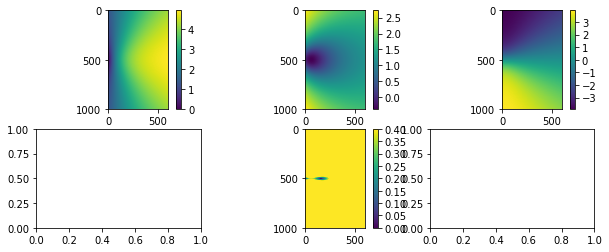

In [3]:
gid.Ang2Q.init_area('y+','x+',500,0,1001,601, distance=10,pwidth1=0.075,pwidth2=0.075)
print(gid.Ang2Q(0,0,10,10))
print(gid.Ang2Q(5,0,10,10))
Q = gid.Ang2Q.area(25,-90,0,0,en=8000)
fs,axs = subplots(2,3,figsize=(10,4),num='Qxyz')
for ah,tQ in zip(axs[0,:],Q):
    ah.cla()
    ih = ah.imshow(tQ)
    colorbar(mappable=ih,ax=ah)

ah = axs[1,1]
ih = ah.imshow(sqrt((Q[1]**2+Q[2]**2)),clim=[0,.4])
colorbar(mappable=ih,ax=ah)


    

In [4]:
gid.scatplane

array([-6.123234e-17, -1.000000e+00,  0.000000e+00])

In [9]:
import numbers
import numpy
from numpy.linalg import norm
import warnings
import re

# package internal imports
from xrayutilities import math
from xrayutilities import materials
from xrayutilities import utilities
from xrayutilities import cxrayutilities
from xrayutilities import config
from xrayutilities.exception import InputError

# python 2to3 compatibility
try:
    basestring
except NameError:
    basestring = str

# regular expression to check goniometer circle syntax
directionSyntax = re.compile("[xyz][+-]")
circleSyntaxDetector = re.compile("([xyz][+-])|(t[xyz])")
circleSyntaxSample = re.compile("[xyzk][+-]")

class GID(Experiment):

    """
    class describing grazing incidence x-ray diffraction experiments
    the class helps with calculating the angles of Bragg reflections
    as well as it helps with analyzing measured data

    the class describes a four circle (alpha_i,azimuth,twotheta,beta)
    goniometer to help with GID experiments at the ROTATING ANODE.
    3D data can be treated with the use of linear and area detectors.
    see help self.Ang2Q

    Using this class the default sample surface orientation is determined by
    the inner most sample rotation (which is usually the azimuth motor).
    """

    def __init__(self, idir, ndir, **keyargs):
        """
        initialization routine for the GID Experiment class

        idir defines the inplane reference direction (idir points into the PB
           direction at zero angles)
        ndir defines the surface normal of your sample (ndir points along the
           innermost sample rotation axis)

        Parameters
        ----------
        same as for the Experiment base class
        """
        if 'sampleor' not in keyargs:
            keyargs['sampleor'] = 'sam'

        if "qconv" not in keyargs:
            # 2S+2D goniometer
            keyargs['qconv'] = QConversion(['z-', 'x+'], ['x+', 'z-'],
                                           [0, 1, 0])

        Experiment.__init__(self, idir, ndir, **keyargs)

    def Q2Ang(self, Q, trans=True, deg=True, **kwargs):
        """
        calculate the GID angles needed in the experiment
        the inplane reference direction defines the direction were
        the reference direction is parallel to the primary beam
        (i.e. lattice planes perpendicular to the beam)

        Parameters
        ----------
         Q:          a list or numpy array of shape (3) with
                     q-space vector components

        optional keyword arguments:
         trans:      True/False apply coordinate transformation on Q
         deg:        True/Flase (default True) determines if the
                     angles are returned in radians or degrees

        Returns
        -------
        a numpy array of shape (4) with the four GID scattering angles which
        are [alpha_i, azimuth, twotheta, beta]

         alpha_i:    incidence angle to surface (at the moment always 0)
         azimuth:    sample rotation with respect to the inplane reference
                     direction
         twotheta:   scattering angle
         beta:       exit angle from surface (at the moment always 0)
        """

        for k in kwargs.keys():
            if k not in ['trans', 'deg']:
                raise Exception("unknown keyword argument given: allowed are "
                                "'trans': coordinate transformation flag, "
                                "'deg': degree-flag")

        if isinstance(Q, list):
            q = numpy.array(Q, dtype=numpy.double)
        elif isinstance(Q, numpy.ndarray):
            q = Q
        else:
            raise TypeError("Q vector must be a list or numpy array")

        if trans:
            q = self.Transform(q)

        if config.VERBOSITY >= config.INFO_ALL:
            print("XU.GID.Q2Ang: q = %s" % repr(q))

        # set parameters for the calculation
        z = self.Transform(self.ndir)  # z
        y = self.Transform(self.idir)  # y
        x = self.Transform(self.scatplane)  # x

        # check if reflection is inplane
        if numpy.abs(math.VecDot(q, z)) >= 0.001:
            raise InputError("Reflection not reachable in GID geometry (Q: %s)"
                             % str(q))

        # calculate angle to inplane reference direction
        aref = numpy.arctan2(math.VecDot(x, q), math.VecDot(y, q))

        # calculate scattering angle
        qa = math.VecNorm(q)
        tth = 2. * numpy.arcsin(qa / 2. / self.k0)
        azimuth = numpy.pi / 2 + aref + tth / 2.

        if deg:
            ang = [0, numpy.degrees(azimuth), numpy.degrees(tth), 0]
        else:
            ang = [0, azimuth, tth, 0]

        if config.VERBOSITY >= config.INFO_ALL:
            print("XU.GID.Q2Ang: [ai,azimuth,tth,beta] = %s \n difference to "
                  "inplane reference which is %5.2f" % (str(ang), aref))

        return ang

    def Ang2Q(self, ai, phi, tt, beta, **kwargs):
        """
        angular to momentum space conversion for a point detector. Also see
        help GID.Ang2Q for procedures which treat line and area detectors

        Parameters
        ----------
         ai,phi,tt,beta: sample and detector angles as numpy array, lists or
                         Scalars must be given. All arguments must have the
                         same shape or length. However, if one angle is always
                         the same its enough to give one scalar value.

        **kwargs:   optional keyword arguments
            delta:  giving delta angles to correct the given ones for
                    misalignment delta must be an numpy array or list of
                    length 4. Used angles are than ai,phi,tt,beta - delta
            UB:     matrix for conversion from (hkl) coordinates to Q of sample
                    used to determine not Q but (hkl)
                    (default: identity matrix)
            wl:     x-ray wavelength in angstroem (default: self._wl)
            deg:    flag to tell if angles are passed as degree (default: True)

        Returns
        -------
        reciprocal space positions as numpy.ndarray with shape ( * , 3 )
        where * corresponds to the number of points given in the input
        """
        # dummy function to have some documentation string available
        # the real function is generated dynamically in the __init__ routine
        pass

In [5]:
math

<module 'math' from '/home/lemke_h/anaconda3/lib/python3.6/lib-dynload/math.cpython-36m-x86_64-linux-gnu.so'>

In [7]:
Experiment??